# **Skin disease dectection Using CNN(Image Classification)**

## **Importing Libraries**

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## **Hyperparameter Setup**

In [ ]:
img_size = (224, 224)
batch_size = 32
seed = 42

# **Dataset Path**

In [ ]:
data_dir = "/content/drive/MyDrive/SKIN_PROJECT_CLEANED2 copy"

# **Dataset preparation**

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, "train"),
    labels="inferred",
    label_mode="categorical",       # multi-class
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=seed,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, "val"),
    labels="inferred",
    label_mode="categorical",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=seed,
)

Found 2915 files belonging to 6 classes.
Found 418 files belonging to 6 classes.


# **Label Detection**

In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)
print("Detected classes:", class_names)
print("Number of classes:", num_classes)

Detected classes: ['class0_normal', 'class1_acne', 'class2_wrinkles', 'class3_Eczema', 'class4_Rosacea', 'class5_dark_spots']
Number of classes: 6


# **Performance Optimization**

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)

# **Data Augmentation**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.10),
        layers.RandomZoom(0.10),
        layers.RandomContrast(0.15),
    ],
    name="data_augmentation",
)

# **Pretrained Model**

In [ ]:
base_model = keras.applications.EfficientNetB2(
    include_top=False,
    input_shape=img_size + (3,),
    weights="imagenet",
)

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# **Freeze Base**

In [ ]:
base_model.trainable = False

# **Model Architecture**

In [ ]:
inputs = keras.Input(shape=img_size + (3,))
x = data_augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(x)

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)

# Stronger classification head
x = layers.Dense(512, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs, name="msc6_all_classes_model")

model.summary()

Model: "msc6_all_classes_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb2 (Functional)     │ (None, 7, 7, 1408)     │     7,768,569 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       721,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,625,919 (32.91 MB)

 Trainable params: 855,814 (3.26 MB)

 Non-trainable params: 7,770,105 (29.64 MB)

# **Model Compilation**

In [ ]:
loss_fn = keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=loss_fn,
    metrics=["accuracy"],
)

# **Training Callbacks**

In [ ]:
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=7,                # allow more epochs to explore
    restore_best_weights=True
)

checkpoint = keras.callbacks.ModelCheckpoint(
    "best_msc6_model.h5",
    monitor="val_loss",
    save_best_only=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    min_lr=1e-6,
    verbose=1,
)

# **Initial Training**

In [ ]:
epochs_phase1 = 5   # just to fit the new head

history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_phase1,
    callbacks=[early_stop, checkpoint, reduce_lr],
)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7112 - loss: 1.2598

92/92 ━━━━━━━━━━━━━━━━━━━━ 520s 5s/step - accuracy: 0.7120 - loss: 1.2575 - val_accuracy: 0.6603 - val_loss: 1.2339 - learning_rate: 0.0010
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8716 - loss: 0.8050

92/92 ━━━━━━━━━━━━━━━━━━━━ 430s 5s/step - accuracy: 0.8716 - loss: 0.8048 - val_accuracy: 0.7847 - val_loss: 0.9415 - learning_rate: 0.0010
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9086 - loss: 0.6921

92/92 ━━━━━━━━━━━━━━━━━━━━ 475s 5s/step - accuracy: 0.9085 - loss: 0.6921 - val_accuracy: 0.8254 - val_loss: 0.9162 - learning_rate: 0.0010
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 470s 5s/step - accuracy: 0.9207 - loss: 0.6540 - val_accuracy: 0.8038 - val_loss: 0.9439 - learning_rate: 0.0010
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 466s 5s/step - accuracy: 0.9245 - loss: 0.6274 - val_accuracy: 0.8038 - val_loss: 0.9641 - learning_rate: 0.0010


# **Unfreeze Base**

In [ ]:
base_model.trainable = True

# **Layer Freezing**

In [ ]:
fine_tune_from = int(len(base_model.layers) * 0.3)

for layer in base_model.layers[:fine_tune_from]:
    layer.trainable = False

print(
    f"Total layers in base model: {len(base_model.layers)}, "
    f"fine-tuning from layer index: {fine_tune_from}"
)

Total layers in base model: 340, fine-tuning from layer index: 102


# **Training Configuration**

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-5),
    loss=loss_fn,
    metrics=["accuracy"],
)

# **Full Model Training**

In [ ]:
epochs_total = 25          # 5 (phase1) + up to 20 (phase2)
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_total,
    initial_epoch=epochs_phase1,
    callbacks=[early_stop, checkpoint, reduce_lr],
)

Epoch 6/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9767 - loss: 0.5377

92/92 ━━━━━━━━━━━━━━━━━━━━ 869s 9s/step - accuracy: 0.9766 - loss: 0.5377 - val_accuracy: 0.8469 - val_loss: 0.9056 - learning_rate: 3.0000e-05
Epoch 7/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9837 - loss: 0.5225

92/92 ━━━━━━━━━━━━━━━━━━━━ 830s 9s/step - accuracy: 0.9837 - loss: 0.5226 - val_accuracy: 0.8445 - val_loss: 0.8972 - learning_rate: 3.0000e-05
Epoch 8/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9697 - loss: 0.5407

92/92 ━━━━━━━━━━━━━━━━━━━━ 867s 9s/step - accuracy: 0.9697 - loss: 0.5408 - val_accuracy: 0.8469 - val_loss: 0.8858 - learning_rate: 3.0000e-05
Epoch 9/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 861s 9s/step - accuracy: 0.9711 - loss: 0.5380 - val_accuracy: 0.8493 - val_loss: 0.8903 - learning_rate: 3.0000e-05
Epoch 10/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9782 - loss: 0.5277

92/92 ━━━━━━━━━━━━━━━━━━━━ 906s 10s/step - accuracy: 0.9782 - loss: 0.5278 - val_accuracy: 0.8445 - val_loss: 0.8840 - learning_rate: 3.0000e-05
Epoch 11/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9818 - loss: 0.5191

92/92 ━━━━━━━━━━━━━━━━━━━━ 909s 10s/step - accuracy: 0.9819 - loss: 0.5192 - val_accuracy: 0.8517 - val_loss: 0.8815 - learning_rate: 3.0000e-05
Epoch 12/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9841 - loss: 0.5196

92/92 ━━━━━━━━━━━━━━━━━━━━ 829s 9s/step - accuracy: 0.9840 - loss: 0.5197 - val_accuracy: 0.8565 - val_loss: 0.8778 - learning_rate: 3.0000e-05
Epoch 13/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9804 - loss: 0.5164

92/92 ━━━━━━━━━━━━━━━━━━━━ 891s 9s/step - accuracy: 0.9804 - loss: 0.5164 - val_accuracy: 0.8517 - val_loss: 0.8762 - learning_rate: 3.0000e-05
Epoch 14/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 867s 9s/step - accuracy: 0.9786 - loss: 0.5253 - val_accuracy: 0.8469 - val_loss: 0.8836 - learning_rate: 3.0000e-05
Epoch 15/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9812 - loss: 0.5165

92/92 ━━━━━━━━━━━━━━━━━━━━ 888s 10s/step - accuracy: 0.9812 - loss: 0.5165 - val_accuracy: 0.8541 - val_loss: 0.8677 - learning_rate: 3.0000e-05
Epoch 16/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 844s 9s/step - accuracy: 0.9844 - loss: 0.5147 - val_accuracy: 0.8493 - val_loss: 0.8764 - learning_rate: 3.0000e-05
Epoch 17/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9890 - loss: 0.5102

92/92 ━━━━━━━━━━━━━━━━━━━━ 842s 9s/step - accuracy: 0.9890 - loss: 0.5102 - val_accuracy: 0.8565 - val_loss: 0.8675 - learning_rate: 3.0000e-05
Epoch 18/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 857s 9s/step - accuracy: 0.9722 - loss: 0.5284 - val_accuracy: 0.8589 - val_loss: 0.8692 - learning_rate: 3.0000e-05
Epoch 19/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9903 - loss: 0.5047

92/92 ━━━━━━━━━━━━━━━━━━━━ 846s 9s/step - accuracy: 0.9902 - loss: 0.5048 - val_accuracy: 0.8565 - val_loss: 0.8632 - learning_rate: 3.0000e-05
Epoch 20/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 888s 9s/step - accuracy: 0.9899 - loss: 0.5056 - val_accuracy: 0.8565 - val_loss: 0.8684 - learning_rate: 3.0000e-05
Epoch 21/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9907 - loss: 0.5014

92/92 ━━━━━━━━━━━━━━━━━━━━ 878s 10s/step - accuracy: 0.9906 - loss: 0.5014 - val_accuracy: 0.8541 - val_loss: 0.8616 - learning_rate: 3.0000e-05
Epoch 22/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9823 - loss: 0.5169

92/92 ━━━━━━━━━━━━━━━━━━━━ 848s 9s/step - accuracy: 0.9824 - loss: 0.5169 - val_accuracy: 0.8565 - val_loss: 0.8534 - learning_rate: 3.0000e-05
Epoch 23/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 852s 9s/step - accuracy: 0.9906 - loss: 0.5017 - val_accuracy: 0.8589 - val_loss: 0.8578 - learning_rate: 3.0000e-05
Epoch 24/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 834s 9s/step - accuracy: 0.9898 - loss: 0.5006 - val_accuracy: 0.8589 - val_loss: 0.8557 - learning_rate: 3.0000e-05
Epoch 25/25
73/92 ━━━━━━━━━━━━━━━━━━━━ 2:44 9s/step - accuracy: 0.9889 - loss: 0.5036

# **Validation Results**

In [ ]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"Final validation accuracy: {val_acc:.4f}")
print("Best model saved as: best_msc6_model.h5")

14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.8553 - loss: 0.8568
Final validation accuracy: 0.8636
Best model saved as: best_msc6_model.h5


## **Visualization**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

## **Evaluate Model Output**

In [ ]:
# Use val_ds or test_ds here
eval_ds = val_ds   # change to test_ds if you have a separate test set

y_true = []
y_pred_probs = []

for images, labels in eval_ds:
    # true labels as class indices
    y_true_batch = np.argmax(labels.numpy(), axis=1)
    y_true.append(y_true_batch)

    # predicted probabilities
    preds = model.predict(images, verbose=0)
    y_pred_probs.append(preds)

y_true = np.concatenate(y_true, axis=0)
y_pred_probs = np.concatenate(y_pred_probs, axis=0)

# predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# class names (ensure you kept this from training)
class_names = eval_ds.class_names if hasattr(eval_ds, "class_names") else class_names
num_classes = len(class_names)

print("y_true shape:", y_true.shape)
print("y_pred_probs shape:", y_pred_probs.shape)
print("y_pred shape:", y_pred.shape)

y_true shape: (418,)
y_pred_probs shape: (418, 6)
y_pred shape: (418,)


# **Performance Metrics**

In [ ]:
# Accuracy
acc = accuracy_score(y_true, y_pred)

# Precision, Recall, F1 (macro and weighted)
precision_macro = precision_score(y_true, y_pred, average="macro", zero_division=0)
recall_macro    = recall_score(y_true, y_pred, average="macro", zero_division=0)
f1_macro        = f1_score(y_true, y_pred, average="macro", zero_division=0)

precision_weighted = precision_score(y_true, y_pred, average="weighted", zero_division=0)
recall_weighted    = recall_score(y_true, y_pred, average="weighted", zero_division=0)
f1_weighted        = f1_score(y_true, y_pred, average="weighted", zero_division=0)

print(f"Accuracy:           {acc:.4f}")
print(f"Precision (macro):  {precision_macro:.4f}")
print(f"Recall (macro):     {recall_macro:.4f}")
print(f"F1-score (macro):   {f1_macro:.4f}")
print(f"Precision (weighted): {precision_weighted:.4f}")
print(f"Recall (weighted):    {recall_weighted:.4f}")
print(f"F1-score (weighted):  {f1_weighted:.4f}")

Accuracy:           0.8636
Precision (macro):  0.6444
Recall (macro):     0.6448
F1-score (macro):   0.6436
Precision (weighted): 0.8281
Recall (weighted):    0.8636
F1-score (weighted):  0.8445


# **Area Under Curve**

In [ ]:
# AUC (works if you have probability outputs and >1 class)
try:
    auc_macro = roc_auc_score(
        y_true,
        y_pred_probs,
        multi_class="ovr",
        average="macro"
    )
    print(f"AUC (macro, OVR):   {auc_macro:.4f}")
except ValueError as e:
    print("AUC could not be computed:", e)

AUC could not be computed: Number of classes in y_true not equal to the number of columns in 'y_score'


# **Performance Summary**

In [ ]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, labels=range(num_classes), zero_division=0))


Classification Report:
                   precision    recall  f1-score   support

    class0_normal       0.86      0.94      0.90       240
      class1_acne       0.00      0.00      0.00         0
  class2_wrinkles       0.90      0.90      0.90       100
    class3_Eczema       0.00      0.00      0.00        17
   class4_Rosacea       0.00      0.00      0.00         0
class5_dark_spots       0.82      0.74      0.78        61

         accuracy                           0.86       418
        macro avg       0.43      0.43      0.43       418
     weighted avg       0.83      0.86      0.84       418



# **Confusion Matrix**

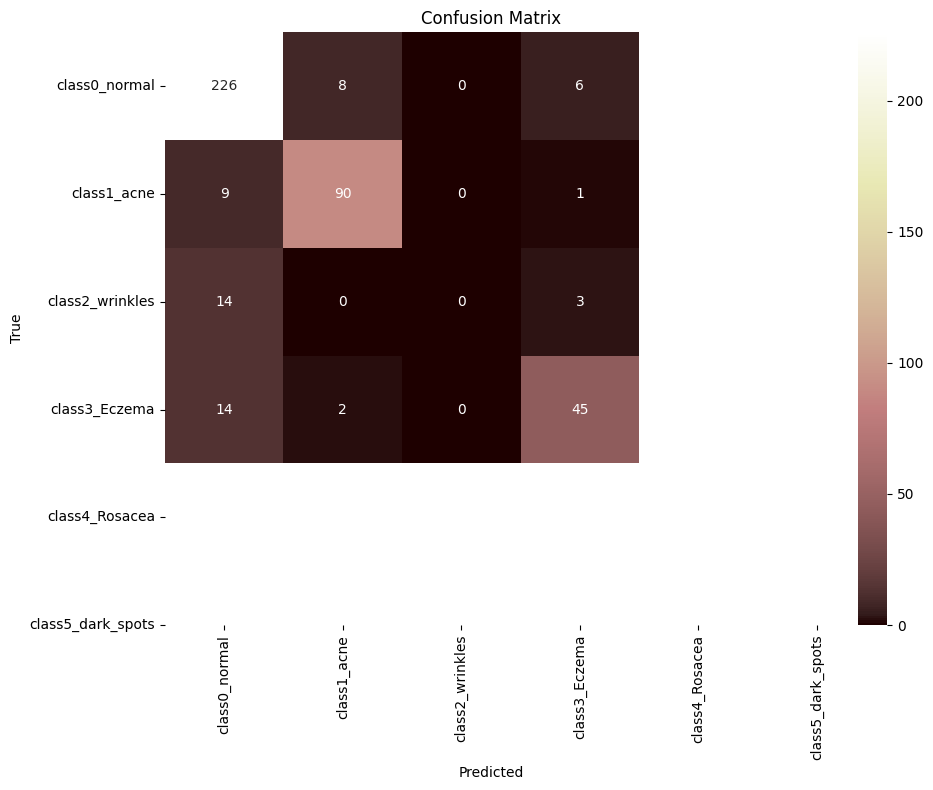

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="pink",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()